In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from clean_data import *

## Clean data and dimension reduction

In [19]:
# Prepare data for person 4. Use sequence 1~3 for training, 4~5 for testing.
person = 4
sadl_n = []
for n in range(1, 6):
    sadl_n.append(pd.read_table('data/S%d-ADL%d.dat' % (person, n), sep='\s+', header=None, dtype=float))

In [20]:
# Smooth data, time: col 0, features: col 1~36, labels: col 244 
winsize = 15
stepsize = 8

# train data
train_sample = np.empty((0, 36))
train_labels = np.empty((0))
train_len = []
for i in range(0, 3):
    features = moving_avg(sadl_n[i].iloc[:, 1:37], winsize, stepsize)
    labels = moving_vote_majority(sadl_n[i].iloc[:, 244], winsize, stepsize)
    train_sample = np.concatenate((train_sample, features), axis=0)
    train_len.append(features.shape[0])
    train_labels = np.concatenate( (train_labels, labels) )
train_len = np.array(train_len)

print "train_sample size: ", train_sample.shape
print "train_labels size: ", train_labels.shape
print "subsequence length: ", train_len, ". Sum of length: ", np.sum(train_len)

# test data
test_sample = np.empty((0, 36))
test_labels = np.empty((0))
test_len = []
for i in range(3, 5):
    features = moving_avg(sadl_n[i].iloc[:, 1:37], winsize, stepsize)
    labels = moving_vote_majority(sadl_n[i].iloc[:, 244], winsize, stepsize)
    test_sample = np.concatenate((test_sample, features), axis=0)
    test_len.append(features.shape[0])
    test_labels = np.concatenate( (test_labels, labels) )
test_len = np.array(test_len)  

print "test_sample size: ", test_sample.shape
print "test_labels size: ", test_labels.shape
print "subsequence length: ", test_len, ". Sum of length: ", np.sum(test_len)


train_sample size:  (11809, 36)
train_labels size:  (11809,)
subsequence length:  [5199 3468 3142] . Sum of length:  11809
test_sample size:  (6595, 36)
test_labels size:  (6595,)
subsequence length:  [2779 3816] . Sum of length:  6595


In [21]:
# Fill missing values
col_threshold = 0.5
train, test = fill_missing(train_sample, test_sample, col_threshold, True)
np.any(np.isnan(train)), np.any(np.isnan(test))

(False, False)

In [22]:
# # Dimension reduction
# from sklearn.decomposition import PCA
# pca = PCA()
# pca.fit(train)
# var_thres = 0.95 # keep components to up to 95% total variance
# n_comp = (pca.explained_variance_ratio_.cumsum() < var_thres).sum() + 1
# print "Keep %d compoments to retrain %f variance" % (n_comp, var_thres)

# pca_train = PCA(n_components=n_comp)
# train_reduced = pca_train.fit_transform(train)
# test_reduced = pca_train.fit_transform(test)
# print "Size of reduced dimension training data: ", train_reduced.shape
# print "Size of reduced dimension testing data: ", test_reduced.shape

train_reduced = train
test_reduced = test

In [23]:
# Cleaned data: train_reduced, test_reduced, train_labels, test_labels, train_len, test_len


## Build hmm model

In [24]:
from hmm import DiscreteDistr, GaussDistr, GaussMixDistr
from hmm import MarkovChain
from hmm import HMM, make_leftright_hmm

# Build a left-right hmm with 6 states, discrete output distribution, the output is the discrete label of activity
label_transfer = (np.maximum(train_labels - 100, 0) + 1)[:, np.newaxis]
# transform the labels into range 1~6. {0: 1, 101: 2, 102: 3, 103: 4, 104: 5, 105: 6}
discreteD = DiscreteDistr(np.ones((6))) # a discrete distribution with 6 possible output
n_states = 6

hmm_state = make_leftright_hmm(n_states, discreteD, obs_data=label_transfer, l_data=train_len)
hmm_state.state_gen.transition_prob

array([[ 0.99845352,  0.00154648,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.998577  ,  0.001423  ,  0.        ,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.99787968,  0.00212032,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.99897959,  0.00102041,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.99856331,
         0.00143669,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.99772359,  0.00227641]])

In [25]:
# Assume there is 1-to-1 mapping between the hidden state and output label
# Assign max probability activity label to each state
state_act_label = np.array([np.argmax(hmm_state.output_distr[i].prob_mass) for i in range(0, n_states)])
act_label_count = np.zeros((n_states)) # how many states correspond to label i
for i in range(0, n_states):
    act_label_count[i] = np.sum(state_act_label == i)
print act_label_count, state_act_label

transition_prob = hmm_state.state_gen.transition_prob
print "transition prob for left-right hmm: "
print transition_prob
# Resolve conflicts: when multiple states have the same activity label (a bit of heuristic)
for n in range(0, n_states):
    if act_label_count[n] > 1:
        t_states = [j for j in range(0, n_states) if state_act_label[j] == n] # n is the activity label
        for s1 in t_states:
            # allow s1 to transition into other states in t_states
            for s2 in t_states:
                if s2 != s1:
                    transition_prob[s1, s2] += 1e-4
                    transition_prob[s1, s1] -= 1e-4

# Train new hmm
hmm_state.transition_prob = transition_prob
hmm_state.train(obs_data=label_transfer, l_data=train_len)

state_act_label = np.array([np.argmax(hmm_state.output_distr[i].prob_mass) for i in range(0, n_states)])
actlabel2state = np.argsort(state_act_label)
print "state to activity label: ", state_act_label
print "activity label to state:", actlabel2state
print "transition prob before permutation:"
hmm_state.state_gen.transition_prob

[ 2.  0.  1.  1.  1.  1.] [0 3 2 5 4 0]
transition prob for left-right hmm: 
[[ 0.99845352  0.00154648  0.          0.          0.          0.          0.        ]
 [ 0.          0.998577    0.001423    0.          0.          0.          0.        ]
 [ 0.          0.          0.99787968  0.00212032  0.          0.          0.        ]
 [ 0.          0.          0.          0.99897959  0.00102041  0.          0.        ]
 [ 0.          0.          0.          0.          0.99856331  0.00143669
   0.        ]
 [ 0.          0.          0.          0.          0.          0.99772359
   0.00227641]]
state to activity label:  [0 3 2 5 4 1]
activity label to state: [0 5 2 1 4 3]
transition prob before permutation:


array([[ 0.994842  ,  0.00184189,  0.        ,  0.        ,  0.        ,
         0.00331611,  0.        ],
       [ 0.        ,  0.99760198,  0.00239802,  0.        ,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.99639766,  0.00360234,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.99830099,  0.00169901,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.99752868,
         0.00247132,  0.        ],
       [ 0.01679036,  0.        ,  0.        ,  0.        ,  0.        ,
         0.97863125,  0.00457839]])

In [26]:
# Reorder the Markov chain in the order of activity labels
transprob_new = hmm_state.state_gen.transition_prob
transprob_new = transprob_new[actlabel2state, :]
transprob_new[:, :n_states] = transprob_new[:, actlabel2state]
# Reorder initial prob
initprob_new = hmm_state.state_gen.initial_prob[actlabel2state]
mc_label = MarkovChain(q=initprob_new, A=transprob_new)
print "transition prob after permutation:"
transprob_new

transition prob after permutation:


array([[ 0.994842  ,  0.00331611,  0.        ,  0.00184189,  0.        ,
         0.        ,  0.        ],
       [ 0.01679036,  0.97863125,  0.        ,  0.        ,  0.        ,
         0.        ,  0.00457839],
       [ 0.        ,  0.        ,  0.99639766,  0.        ,  0.        ,
         0.00360234,  0.        ],
       [ 0.        ,  0.        ,  0.00239802,  0.99760198,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.00247132,  0.        ,  0.        ,  0.99752868,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.00169901,
         0.99830099,  0.        ]])

In [27]:
# Train output distribution
train_label_transfer = np.maximum(0, train_labels - 100)
outputdistr_gmm = []
n_mix = [3, 4, 6, 6, 4, 5]
for i in range(0, n_states):
    gmm = GaussMixDistr(gauss=n_mix[i])
    gmm.init_by_data(train_reduced[train_label_transfer == i, :])
    gmm.train(train_reduced[train_label_transfer == i, :])
    outputdistr_gmm.append(gmm)
    
for i in range(0, n_states):
    print i, len(outputdistr_gmm[i].gaussians)
    print outputdistr_gmm[i].mix_weight

0 3
[ 0.33294079  0.54466198  0.12239724]
1 4
[ 0.29657444  0.32905909  0.37436647  0.        ]
2 6
[ 0.1666667   0.16666664  0.16666664  0.16666672  0.16666665  0.16666664]
3 6
[ 0.26596831  0.1456456   0.14286377  0.15331029  0.14608806  0.14612398]
4 4
[ 0.          0.55876519  0.          0.44123481]
5 5
[ 0.12389087  0.51797361  0.35813552  0.          0.        ]


In [28]:
outputdistr_gmm[0].data_size

36

In [29]:
# Make new hmm
hmm_gmm = HMM(markov_chain=mc_label, output_distr=outputdistr_gmm)

accuracy:  0.636200071968


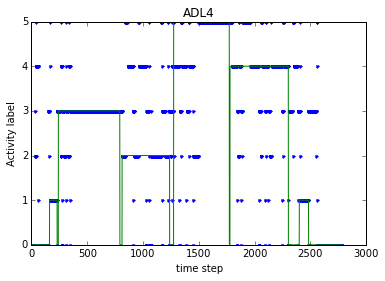

In [33]:
# Test with ADL4, ADL5
seq4, logP4 = hmm_gmm.viterbi(test_reduced[:test_len[0], :])
seq5, logP5 = hmm_gmm.viterbi(test_reduced[test_len[0]: test_len[0] + test_len[1], :])

plt.plot(seq4 - 1, '.', label="estimated label")
plt.plot(np.maximum(0, test_labels[: test_len[0]] - 100), '-', label="true label")
plt.xlabel('time step')
plt.ylabel('Activity label')
plt.title("ADL4")

predicted_4 = seq4 - 1
true_4 = np.maximum(0, test_labels[: test_len[0]] - 100)
print "accuracy: ", sum(predicted_4 == true_4) / float(test_len[0])

In [34]:
logP4

-661091.10298043129

In [35]:
logP5

-907403.68986106454

In [36]:
np.sum(mc_label.transition_prob == 0)

28